# Apprenticeship Learning via IRL with Traditional Q Learning Algorithm using Epislon Greedy Strategy

### Reference:
- [1] P. Abbeel and A. Y. Ng, “Apprenticeship Learning via Inverse Reinforcement Learning.”

- [2] OpenAI Gym, Greg Brockman and Vicki Cheung and Ludwig Pettersson and Jonas Schneider and John Schulman and Jie Tang and Wojciech Zaremba 2016 
- [3] Phil Tabor, OpenAI-Cartpole, (2017), GitHub repository, https://github.com/philtabor/OpenAI-Cartpole

- This notebook demonstrates solving the CartPole model from open AI gym using the Inverse Reinforcement Learning outlined in paper _Apprenticeship Learning via Inverse Reinforcement Learning_

- This algorithm requies a expert demonstration as an input, and learned from it.

- For the sole purpose of demonstration, the expert demonstration used here is an algorithm learned from a traditional Q learning implementation, with discretized observable state space. And the IRL algorithm learns from that demonstration.

## Model Overview

### Details
* Name: CartPole-v0  
* Category: Classic Control
* [Leaderboard Page](https://github.com/openai/gym/wiki/Leaderboard#cartpole-v0)
* Old links:
  * [Environment Page](https://gym.openai.com/envs/CartPole-v0)  
  * [Algorithms Page](https://gym.openai.com/algorithms?groups=classic_control)

### Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

### Source
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson 


## Environment

### Observation
Type: Box(4)

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

### Actions
Type: Discrete(2)

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Reward
Reward is 1 for every step taken, including the termination step

### Starting State
All observations are assigned a uniform random value between ±0.05

### Episode Termination
1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

### Solved Requirements
Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

In [1]:
import gym
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import time
import sys
import math
import seaborn as sns

In [2]:
env = gym.make('CartPole-v0')

nbins = 10
GAMMA = 0.9
ALPHA = 0.01

In [3]:
def max_dict(d): 
    """
    looking for the action that gives the maximum value for a given state
    """
    max_v = float('-inf')
    for key, val in d.items():
        if val > max_v:
            max_v = val
            max_key = key
    return max_key, max_v

In [4]:
def create_bins(): 
    """
    create bins to discretize the continuous observable state space
    """
    # obs[0] -> cart position --- -4.8 - 4.8
    # obs[1] -> cart velocity --- -inf - inf
    # obs[2] -> pole angle    --- -41.8 - 41.8
    # obs[3] -> pole velocity --- -inf - inf

    bins = np.zeros((4,nbins))
    bins[0] = np.linspace(-4.8, 4.8, nbins)
    bins[1] = np.linspace(-5, 5, nbins)
    bins[2] = np.linspace(-.418, .418, nbins)
    bins[3] = np.linspace(-5, 5, nbins)
    return bins

In [5]:
def assign_bins(observation, bins): 
    """
    discretizing the continuous observation space into state
    """
    state = np.zeros(4)
    for i in range(4):
        state[i] = np.digitize(observation[i], bins[i])
    return state

In [6]:
def get_state_as_string(state):
    """
    encoding the state into string as dictionary
    """
    string_state=''
    for e in state:
            string_state = string_state+str(int(e)).zfill(2)
    return string_state

In [7]:
def get_all_states_as_string():
    states = []
    for i in range (nbins+1):
        for j in range (nbins+1):
            for k in range(nbins+1):
                for l in range(nbins+1):
                    a=str(i).zfill(2)+str(j).zfill(2)+str(k).zfill(2)+str(l).zfill(2)
                    states.append(a)
    return states

In [8]:
def initialize_Q():
    """
    initialize your Q table
    """
    Q = {}

    all_states = get_all_states_as_string()
    for state in all_states:
        Q[state] = {}
        for action in range(env.action_space.n):
            Q[state][action] = 0
    return Q

In [9]:
def play_one_game(bins, Q, eps=0.5):
    """
    train 1 episode
    """
    observation = env.reset()
    done = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0

    while not done:
        cnt += 1
        # np.random.randn() seems to yield a random action 50% of the time ?
        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]

        observation, reward, done, _ = env.step(act)

        total_reward += reward

        if done and cnt < 200:
            reward = -300

        state_new = get_state_as_string(assign_bins(observation, bins))

        a1, max_q_s1a1 = max_dict(Q[state_new])
        Q[state][act] += ALPHA*(reward + GAMMA*max_q_s1a1 - Q[state][act])
        state, act = state_new, a1

    return total_reward, cnt

In [10]:
def play_many_games(bins, N=10000):
    """
    train many episodes
    """
    Q = initialize_Q()

    length = []
    reward = []
    for n in range(N):
        #eps=0.5/(1+n*10e-3)
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length= play_one_game(bins, Q, eps)

        if n % 100 == 0:
            clear_output(wait=True)
            print("Episode: %d, Epislon: %.4f, Reward %d"%(n,eps,episode_reward))
        length.append(episode_length)
        reward.append(episode_reward)
    env.close()
    return length, reward, Q

In [11]:
def plot_running_avg(totalrewards):
    """
    plotting the average reward during training
    """
    
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [12]:
def play_policy(bins,Q,N=1000,render=False,delay=0.01):
    """
    run an environment using a trained policy
    """
    
    totalReward=[]
    steps=[]
    for n in range(N):
        observation=env.reset()
        done=False
        episodeReward=0
        while not done:
            if render:
                env.render()
                time.sleep(delay)
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
#             print(act)
            observation,reward,done,_=env.step(act)
            episodeReward+=reward
        totalReward.append(episodeReward)
    env.close()
    return totalReward

## Finding Expert Policy

Here we train a tradition Q-learning to use as the expert policy that we want the apprenticeship IRL algorithm to learn from. The reward obtained from each state-action pair is stored in a 10000 x 2 array, where the rows are the states and columns are the actions. Each cell is a reward associated with the state-action pair. The algorithm uses epislon-greedy approach choose its actions, and updates its Q table through the training iterations. This Q table is the policy.

In [13]:
bins = create_bins()

Episode: 19900, Epislon: 0.0071, Reward 200


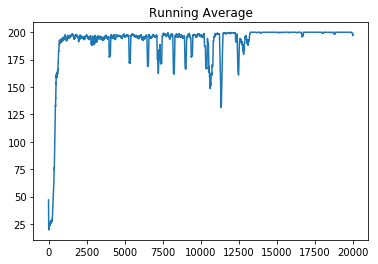

In [14]:
episode_lengths, episode_rewards, expert_Q=play_many_games(bins,N=20000)

plot_running_avg(episode_rewards)

In [15]:
print("export trained expert model...")
filename = 'expert_Q'
outfile = open(filename,'wb')
pickle.dump(expert_Q,outfile)
outfile.close()

export trained expert model...


# Demonstrate Expert Policy

Here we show the training result. Using the trained policy, we run the environment 10000 times to look at the reward distribution. 

Text(0, 0.5, 'Frequency')

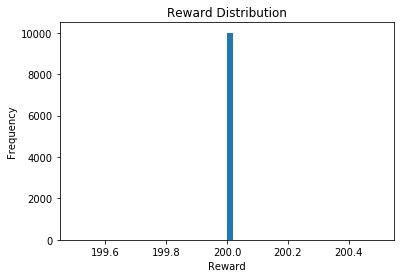

In [16]:
expertReward=play_policy(bins,expert_Q,N=10000,render=False)

plt.hist(expertReward,bins=50)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")

We render the environment to visualize the policy in action.

expertReward=play_policy(bins,expert_Q,N=1,render=True,delay=0.05)

In [17]:
env.close()

# Build IRL Algorithm

Here we define some additional functions for our algorithm.

### **Import notes:** 
1. the Q-learning algorithm is now modified. It discards the returned reward from the training environment and uses uses the reward function $R(s,a)=w^T\phi(s)$, where $w$ is the weight found through the IRL algorithm, and $\phi(s)$ is the observation space
2. To have the observation features between [0,1] for calculating feature expectation, the each feature element is passed through a sigmoid function to do the mapping. 
$$y=\frac{1}{1+e^{-x}}$$


In [18]:
def sigmoid(arry):
    sig=[]
    for i in arry:
        sig.append(1/(1+math.exp(-i)))           
    return np.array(sig)

In [19]:
def getFeatureExpectation(Q,N=1000):
    observationSum=np.zeros(4)
    for i in range(N):
        observation=env.reset()
        done=False
        cnt=0
        while not done:
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
            observation,reward,done,_=env.step(act)
            observation=sigmoid(observation)
            observationSum+=(GAMMA**cnt)*observation
            cnt+=1
    featureExpectation=observationSum/N
    
    print("FeatureExpectation: ",featureExpectation)
    return featureExpectation

In [20]:
def irl_play_one_game(bins,weight,Q,eps=0.5):
    observation = env.reset()
    done = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0
    

    while not done:
        cnt += 1
        # np.random.randn() seems to yield a random action 50% of the time ?
        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]

        observation, reward, done, _ = env.step(act)
        #discard the simulation reward, and use the reward function found from irl algorithm
        reward = np.dot(weight,observation)

        total_reward += reward

        if done and cnt < 200:
            reward = -300

        state_new = get_state_as_string(assign_bins(observation, bins))

        a1, max_q_s1a1 = max_dict(Q[state_new])
        Q[state][act] += ALPHA*(reward + GAMMA*max_q_s1a1 - Q[state][act])
        state, act = state_new, a1

    return total_reward, cnt

In [21]:
def irl_play_many_games(bins,weight,N=10000):
    Q = initialize_Q()
    length = []
    reward = []
    for n in range(N):
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length= irl_play_one_game(bins, weight,Q,eps)

        length.append(episode_length)
        reward.append(episode_reward) 
    print("Avg Length %d"%(np.average(length)))
    print("standard deviation %d"%(np.std(length)))
    return np.average(length), reward, Q

In [22]:
expertExpectation=getFeatureExpectation(expert_Q)

FeatureExpectation:  [3.44402693 2.53628168 3.57102133 4.78042769]


Here we start the training of the IRL algorithm using projection method. Refer to P. Abbeel and A. Y. Ng, “Apprenticeship Learning via Inverse Reinforcement Learning.” for the algorithm below.

In [23]:
#either terminate with margin or iteration
epislon=0.00002
N=10

weight=[]
featureExpectation=[]
featureExpectationBar=[]
learnedQ=[]
margin=[]
avgEpisodeLength=[]

for i in range(N):
    print("Iteration: ",i)
    if i==0: #step1, initialization
        initialQ=initialize_Q() #give random initial policy
        featureExpectation.append(getFeatureExpectation(initialQ))
        print("expert feature Expectation: ", expertExpectation)
        learnedQ.append(initialQ) #put in the initial policy
        weight.append(np.zeros(4)) #put in a dummy weight
        margin.append(0.05) #put in a dummy margin
    else:#first iter of step 2
        if i==1:
            featureExpectationBar.append(featureExpectation[i-1])
            weight.append(expertExpectation-featureExpectation[i-1])
            margin.append(norm((expertExpectation-featureExpectationBar[i-1]),2))

            print("margin: ",margin[i])
            print("weight: ",weight[i])

        else: #iter 2 and on of step 2
            A=featureExpectationBar[i-2]
            B=featureExpectation[i-1]-A
            C=expertExpectation-featureExpectationBar[i-2]
            featureExpectationBar.append(A+(np.dot(B,C)/np.dot(B,B))*(B))

            weight.append(expertExpectation-featureExpectationBar[i-1])
            margin.append(norm((expertExpectation-featureExpectationBar[i-1]),2))

            print("margin: ",margin[i])
            print("weight: ",weight[i])
            
        #step3,terminate condition    
        if (margin[i]<=epislon):
            break

        #step4
        episode_lengths, episode_rewards, learnedQ_i= irl_play_many_games(bins,weight[i])
        learnedQ.append(learnedQ_i)
        avgEpisodeLength.append(episode_lengths)
        #step5
        featureExpectation.append(getFeatureExpectation(learnedQ[i]))
    
    print("")

print("export trained IRL model...")
filename = 'learnedQ'
outfile = open(filename,'wb')
pickle.dump(learnedQ,outfile)
outfile.close()

Iteration:  0
FeatureExpectation:  [3.05621537 1.92080148 3.22590346 4.75811301]
expert feature Expectation:  [3.44402693 2.53628168 3.57102133 4.78042769]

Iteration:  1
margin:  0.805492376496219
weight:  [0.38781156 0.6154802  0.34511787 0.02231468]
Avg Length 181
standard deviation 36
FeatureExpectation:  [3.07064507 1.94626087 3.23998151 4.75478259]

Iteration:  2
margin:  0.10971748674319597
weight:  [ 0.03508453 -0.00686199  0.00098681  0.10372532]
Avg Length 184
standard deviation 33
FeatureExpectation:  [3.07144172 1.94221047 3.23928851 4.76282978]

Iteration:  3
margin:  0.10971139071608312
weight:  [ 0.03559192 -0.00595856  0.00148405  0.10359584]
Avg Length 187
standard deviation 29
FeatureExpectation:  [3.07929071 1.94345477 3.24572093 4.77612292]

Iteration:  4
margin:  0.1096898318244739
weight:  [ 0.03653058 -0.00425093  0.00240751  0.10331268]
Avg Length 189
standard deviation 27
FeatureExpectation:  [3.07730041 1.94938429 3.24373318 4.76221007]

Iteration:  5
margin: 

## Training Result

Text(0, 0.5, 'Distance')

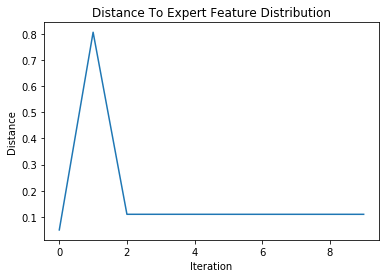

In [24]:
#Plotting Convergence Rate
plt.plot(margin)
plt.title("Distance To Expert Feature Distribution")
plt.xlabel("Iteration")
plt.ylabel("Distance")

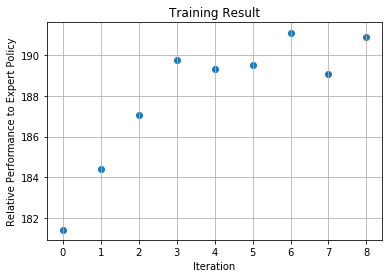

In [25]:
iteration=[]
for i in range(np.size(avgEpisodeLength)):
    iteration.append(i)
plt.scatter(iteration,avgEpisodeLength)
plt.xlabel("Iteration")
plt.ylabel("Relative Performance to Expert Policy")
plt.title("Training Result")
plt.grid()

uReward=play_policy(bins,untrainedPolicy,N=1,render=True,delay=0.05)

intReward=play_policy(bins,intermediatePolicy,N=1,render=True,delay=0.05)

irlReward=play_policy(bins,bestPolicy,N=1,render=True,delay=0.05)

expertReward=play_policy(bins,expert_Q,N=1,render=True,delay=0.05)